In [1]:
import pandas as pd
from datasets import load_dataset, Dataset, DatasetDict

reddit_df = pd.read_csv('the-reddit-dataset-dataset-comments.csv')
reddit_df = reddit_df.dropna(subset=['body', 'sentiment'])
reddit_df['body'] = reddit_df['body'].astype(str)
reddit_df['sentiment'] = reddit_df['sentiment'].astype(float)
def assign_label(score):
    if score < -0.5:
        return 0  # Negative
    elif -0.5 <= score <= 0.5:
        return 1  # Neutral
    else:
        return 2  # Positive

reddit_df['text'] = reddit_df['body']
reddit_df['label'] = reddit_df['sentiment'].apply(assign_label)
reddit_df = reddit_df[['text', 'label']]
reddit_data = Dataset.from_pandas(reddit_df)


reddit_dataset = DatasetDict({
    'test': reddit_data
})


In [2]:


# Load the sentiment analysis dataset
dataset = load_dataset("cardiffnlp/tweet_eval", "sentiment")



In [3]:
from transformers import AutoTokenizer

# Load GPT-2 tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Tokenize the data
def preprocess_function(examples):
    tokenized = tokenizer(
        examples['text'],
        truncation=True,
        padding="max_length",
        max_length=128
    )
    tokenized["labels"] = examples["label"]  # Add labels to the tokenized dataset
    return tokenized

tokenized_datasets = dataset.map(preprocess_function, batched=True)
reddit_tokenized_datasets = reddit_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/47370 [00:00<?, ? examples/s]

In [4]:
from transformers import AutoModelForSequenceClassification

import torch

# Set the device to MPS explicitly
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Load GPT-2 with a classification head
model = AutoModelForSequenceClassification.from_pretrained("gpt2", num_labels=3) 
model.config.pad_token_id = tokenizer.pad_token_id
model.to(device)


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=3, bias=False)
)

In [5]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    save_total_limit=2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer
)

/Users/srinathsureshkumar/miniconda3/envs/bda/lib/python3.12/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/_v/9p5rkkbj79d0bmthxllw7rqm0000gn/T/ipykernel_60765/332406667.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/1536 [00:00<?, ?it/s]

Tweet Accuracy: 0.1940735916639531
Tweet Precision: 0.31304360490240596
Tweet Recall: 0.3335009371514451
Tweet F1 Score: 0.10978885797200327
Tweet Accuracy: 0.1940735916639531


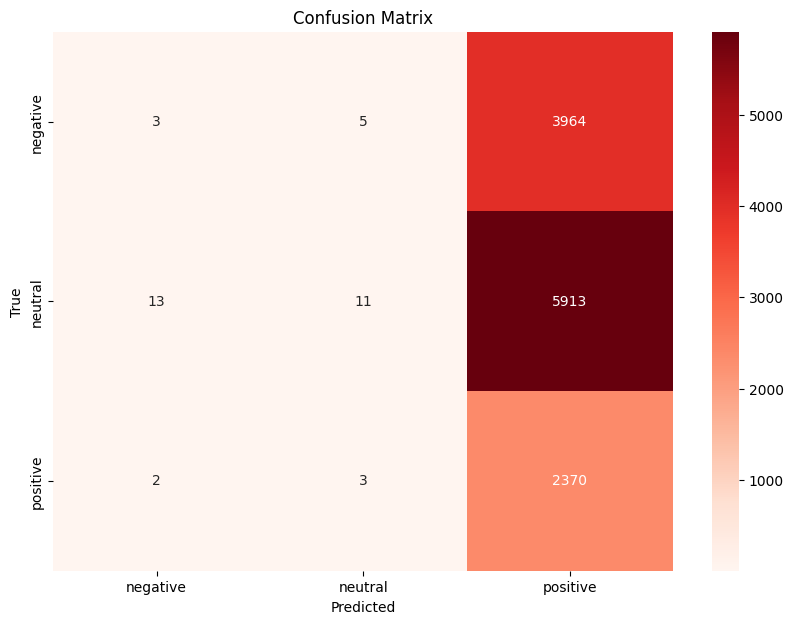

In [6]:
predictions = trainer.predict(tokenized_datasets['test'])
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

accuracy = accuracy_score(tokenized_datasets['test']['label'], predicted_labels)
precision = precision_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')
recall = recall_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')
f1_score_ = f1_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')

print(f'Tweet Accuracy: {accuracy}')
print(f'Tweet Precision: {precision}')
print(f'Tweet Recall: {recall}')
print(f'Tweet F1 Score: {f1_score_}')
print(f'Tweet Accuracy: {accuracy}')

conf_matrix = confusion_matrix(tokenized_datasets['test']['labels'], predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
predictions = trainer.predict(reddit_tokenized_datasets['test'])
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

accuracy = accuracy_score(reddit_tokenized_datasets['test']['label'], predicted_labels)
precision = precision_score(reddit_tokenized_datasets['test']['label'], predicted_labels, average='macro')
recall = recall_score(reddit_tokenized_datasets['test']['label'], predicted_labels, average='macro')
f1_score_ = f1_score(reddit_tokenized_datasets['test']['label'], predicted_labels, average='macro')

print(f'Reddit Accuracy: {accuracy}')
print(f'Reddit Precision: {precision}')
print(f'Reddit Recall: {recall}')
print(f'Reddit F1 Score: {f1_score_}')
print(f'Reddit Accuracy: {accuracy}')


  0%|          | 0/5922 [00:00<?, ?it/s]

Reddit Accuracy: 0.3657378087397087
Reddit Precision: 0.3228848514268619
Reddit Recall: 0.3359224962877079
Reddit F1 Score: 0.19598182414785123
Reddit Accuracy: 0.3657378087397087


ValueError: Found input variables with inconsistent numbers of samples: [12284, 47370]

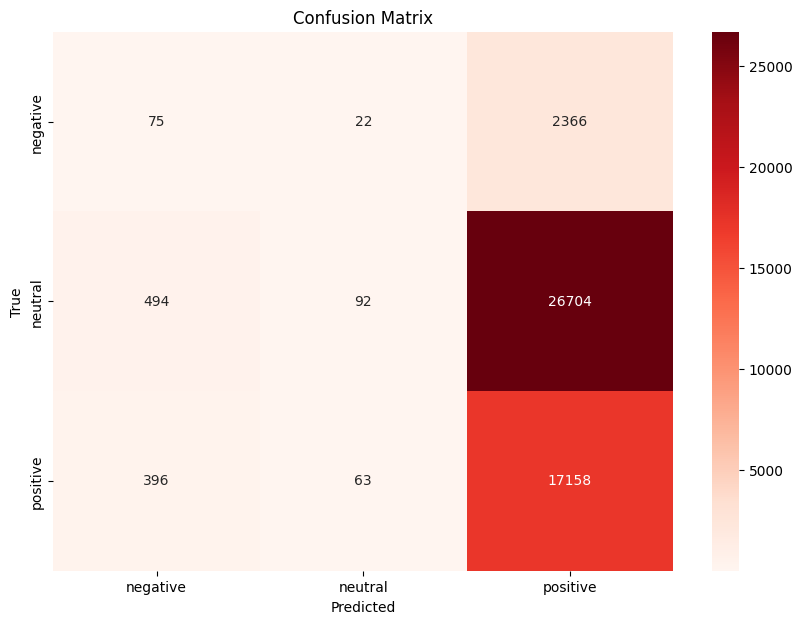

In [8]:

conf_matrix = confusion_matrix(reddit_tokenized_datasets['test']['labels'], predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [9]:
trainer.train()

  0%|          | 0/17106 [00:00<?, ?it/s]

{'loss': 0.8863, 'grad_norm': 48.36246109008789, 'learning_rate': 1.9415409797731793e-05, 'epoch': 0.09}
{'loss': 0.7262, 'grad_norm': 33.164024353027344, 'learning_rate': 1.883081959546358e-05, 'epoch': 0.18}
{'loss': 0.7083, 'grad_norm': 21.586814880371094, 'learning_rate': 1.824622939319537e-05, 'epoch': 0.26}
{'loss': 0.6703, 'grad_norm': 17.870548248291016, 'learning_rate': 1.7661639190927163e-05, 'epoch': 0.35}
{'loss': 0.6761, 'grad_norm': 27.838346481323242, 'learning_rate': 1.707704898865895e-05, 'epoch': 0.44}
{'loss': 0.6758, 'grad_norm': 19.12727928161621, 'learning_rate': 1.649245878639074e-05, 'epoch': 0.53}
{'loss': 0.6656, 'grad_norm': 26.03387451171875, 'learning_rate': 1.5907868584122533e-05, 'epoch': 0.61}
{'loss': 0.6651, 'grad_norm': 31.679595947265625, 'learning_rate': 1.532327838185432e-05, 'epoch': 0.7}
{'loss': 0.642, 'grad_norm': 24.993610382080078, 'learning_rate': 1.4738688179586112e-05, 'epoch': 0.79}
{'loss': 0.6297, 'grad_norm': 31.219697952270508, 'learn

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.6254441142082214, 'eval_model_preparation_time': 0.0007, 'eval_runtime': 21.0585, 'eval_samples_per_second': 94.973, 'eval_steps_per_second': 11.872, 'epoch': 1.0}
{'loss': 0.5872, 'grad_norm': 48.606998443603516, 'learning_rate': 1.2984917572781482e-05, 'epoch': 1.05}
{'loss': 0.5681, 'grad_norm': 19.583711624145508, 'learning_rate': 1.2400327370513273e-05, 'epoch': 1.14}
{'loss': 0.5815, 'grad_norm': 15.777647972106934, 'learning_rate': 1.181573716824506e-05, 'epoch': 1.23}
{'loss': 0.557, 'grad_norm': 21.326623916625977, 'learning_rate': 1.1231146965976852e-05, 'epoch': 1.32}
{'loss': 0.57, 'grad_norm': 6.452838897705078, 'learning_rate': 1.0646556763708643e-05, 'epoch': 1.4}
{'loss': 0.5408, 'grad_norm': 20.262462615966797, 'learning_rate': 1.006196656144043e-05, 'epoch': 1.49}
{'loss': 0.5427, 'grad_norm': 7.982975006103516, 'learning_rate': 9.477376359172222e-06, 'epoch': 1.58}
{'loss': 0.5443, 'grad_norm': 23.05189323425293, 'learning_rate': 8.892786156904011e-06

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.6492927074432373, 'eval_model_preparation_time': 0.0007, 'eval_runtime': 20.9441, 'eval_samples_per_second': 95.492, 'eval_steps_per_second': 11.937, 'epoch': 2.0}
{'loss': 0.5482, 'grad_norm': 40.384620666503906, 'learning_rate': 6.554425347831171e-06, 'epoch': 2.02}
{'loss': 0.4776, 'grad_norm': 23.547222137451172, 'learning_rate': 5.969835145562961e-06, 'epoch': 2.1}
{'loss': 0.4698, 'grad_norm': 9.082292556762695, 'learning_rate': 5.38524494329475e-06, 'epoch': 2.19}
{'loss': 0.4795, 'grad_norm': 32.72574996948242, 'learning_rate': 4.800654741026541e-06, 'epoch': 2.28}
{'loss': 0.4759, 'grad_norm': 13.713750839233398, 'learning_rate': 4.216064538758331e-06, 'epoch': 2.37}
{'loss': 0.4753, 'grad_norm': 26.58028221130371, 'learning_rate': 3.6314743364901207e-06, 'epoch': 2.46}
{'loss': 0.4597, 'grad_norm': 7.205330848693848, 'learning_rate': 3.0468841342219106e-06, 'epoch': 2.54}
{'loss': 0.4505, 'grad_norm': 30.065664291381836, 'learning_rate': 2.4622939319537005e-06

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.6810768842697144, 'eval_model_preparation_time': 0.0007, 'eval_runtime': 20.9999, 'eval_samples_per_second': 95.239, 'eval_steps_per_second': 11.905, 'epoch': 3.0}
{'train_runtime': 5830.6549, 'train_samples_per_second': 23.47, 'train_steps_per_second': 2.934, 'train_loss': 0.5720860064134227, 'epoch': 3.0}


TrainOutput(global_step=17106, training_loss=0.5720860064134227, metrics={'train_runtime': 5830.6549, 'train_samples_per_second': 23.47, 'train_steps_per_second': 2.934, 'total_flos': 8939369173155840.0, 'train_loss': 0.5720860064134227, 'epoch': 3.0})

In [10]:
# Evaluate the model
results = trainer.evaluate(tokenized_datasets["test"])
print(results)

# Save the fine-tuned model
model.save_pretrained("./sentiment-gpt2")
tokenizer.save_pretrained("./sentiment-gpt2")

  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.7522904276847839, 'eval_model_preparation_time': 0.0007, 'eval_runtime': 131.6897, 'eval_samples_per_second': 93.28, 'eval_steps_per_second': 11.664, 'epoch': 3.0}


('./sentiment-gpt2/tokenizer_config.json',
 './sentiment-gpt2/special_tokens_map.json',
 './sentiment-gpt2/vocab.json',
 './sentiment-gpt2/merges.txt',
 './sentiment-gpt2/added_tokens.json',
 './sentiment-gpt2/tokenizer.json')

  0%|          | 0/1536 [00:00<?, ?it/s]

Tweet Accuracy: 0.6936665581243895
Tweet Precision: 0.682377636806299
Tweet Recall: 0.7151327482942907
Tweet F1 Score: 0.6935738206376799
Tweet Accuracy: 0.6936665581243895


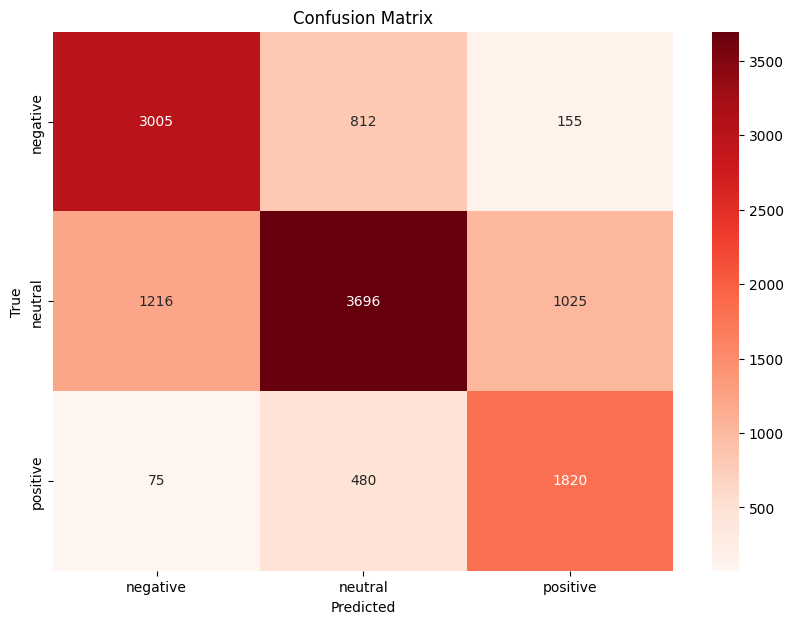

In [11]:
predictions = trainer.predict(tokenized_datasets['test'])
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)

accuracy = accuracy_score(tokenized_datasets['test']['label'], predicted_labels)
precision = precision_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')
recall = recall_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')
f1_score_ = f1_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')

print(f'Tweet Accuracy: {accuracy}')
print(f'Tweet Precision: {precision}')
print(f'Tweet Recall: {recall}')
print(f'Tweet F1 Score: {f1_score_}')
print(f'Tweet Accuracy: {accuracy}')

conf_matrix = confusion_matrix(tokenized_datasets['test']['labels'], predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
dataset = load_dataset("cardiffnlp/super_tweeteval", "tweet_sentiment")
label_mapping = {0: 0, 1: 0, 2: 1, 3: 2, 4: 2}  

def replace_labels(examples, label_mapping):
    examples['label'] = [label_mapping[label] for label in examples['gold_label']]
    return examples

# Replace labels in the dataset using the mapping
dataset = dataset.map(lambda examples: replace_labels(examples, label_mapping), batched=True)


In [ ]:

tokenizer = AutoTokenizer.from_pretrained("./sentiment-gpt2")
tokenizer.pad_token = tokenizer.eos_token


def preprocess_function(examples):
    tokenized = tokenizer(
        examples['text'],
        truncation=True,
        padding="max_length",
        max_length=128
    )
    tokenized["labels"] = examples["label"]  
    return tokenized

tokenized_datasets = dataset.map(preprocess_function, batched=True)
reddit_tokenized_datasets = reddit_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/26632 [00:00<?, ? examples/s]

Map:   0%|          | 0/12379 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/47370 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("./sentiment-gpt2", num_labels=3) 
model.config.pad_token_id = tokenizer.pad_token_id
model.to(device)

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=3, bias=False)
)

In [ ]:

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    save_total_limit=2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer
)

/Users/srinathsureshkumar/miniconda3/envs/bda/lib/python3.12/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/_v/9p5rkkbj79d0bmthxllw7rqm0000gn/T/ipykernel_38104/2710583026.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

  0%|          | 0/9987 [00:00<?, ?it/s]

{'loss': 0.6459, 'grad_norm': 11.397957801818848, 'learning_rate': 1.899869830780014e-05, 'epoch': 0.15}
{'loss': 0.6218, 'grad_norm': 13.151814460754395, 'learning_rate': 1.7997396615600284e-05, 'epoch': 0.3}
{'loss': 0.615, 'grad_norm': 41.42858123779297, 'learning_rate': 1.699609492340042e-05, 'epoch': 0.45}
{'loss': 0.6472, 'grad_norm': 13.1765775680542, 'learning_rate': 1.5994793231200562e-05, 'epoch': 0.6}
{'loss': 0.6324, 'grad_norm': 11.223030090332031, 'learning_rate': 1.4993491539000702e-05, 'epoch': 0.75}
{'loss': 0.604, 'grad_norm': 64.63749694824219, 'learning_rate': 1.3992189846800843e-05, 'epoch': 0.9}


  0%|          | 0/500 [00:00<?, ?it/s]

{'eval_loss': 0.7528280019760132, 'eval_runtime': 42.8303, 'eval_samples_per_second': 93.392, 'eval_steps_per_second': 11.674, 'epoch': 1.0}
{'loss': 0.5947, 'grad_norm': 38.766754150390625, 'learning_rate': 1.2990888154600982e-05, 'epoch': 1.05}
{'loss': 0.5382, 'grad_norm': 32.53646469116211, 'learning_rate': 1.1989586462401122e-05, 'epoch': 1.2}
{'loss': 0.5205, 'grad_norm': 9.45086669921875, 'learning_rate': 1.0988284770201263e-05, 'epoch': 1.35}
{'loss': 0.5201, 'grad_norm': 38.187347412109375, 'learning_rate': 9.986983078001402e-06, 'epoch': 1.5}
{'loss': 0.5201, 'grad_norm': 54.03757858276367, 'learning_rate': 8.985681385801543e-06, 'epoch': 1.65}
{'loss': 0.5239, 'grad_norm': 14.977100372314453, 'learning_rate': 7.984379693601682e-06, 'epoch': 1.8}
{'loss': 0.5085, 'grad_norm': 7.906442165374756, 'learning_rate': 6.9830780014018225e-06, 'epoch': 1.95}


  0%|          | 0/500 [00:00<?, ?it/s]

{'eval_loss': 0.8985701203346252, 'eval_runtime': 42.446, 'eval_samples_per_second': 94.237, 'eval_steps_per_second': 11.78, 'epoch': 2.0}
{'loss': 0.4461, 'grad_norm': 7.235117435455322, 'learning_rate': 5.9817763092019636e-06, 'epoch': 2.1}
{'loss': 0.4419, 'grad_norm': 13.705244064331055, 'learning_rate': 4.980474617002103e-06, 'epoch': 2.25}
{'loss': 0.434, 'grad_norm': 11.022455215454102, 'learning_rate': 3.979172924802243e-06, 'epoch': 2.4}
{'loss': 0.4322, 'grad_norm': 7.844876289367676, 'learning_rate': 2.9778712326023833e-06, 'epoch': 2.55}
{'loss': 0.4293, 'grad_norm': 9.28359603881836, 'learning_rate': 1.9765695404025235e-06, 'epoch': 2.7}
{'loss': 0.4502, 'grad_norm': 25.303466796875, 'learning_rate': 9.752678482026635e-07, 'epoch': 2.85}


  0%|          | 0/500 [00:00<?, ?it/s]

{'eval_loss': 0.9687845706939697, 'eval_runtime': 41.8794, 'eval_samples_per_second': 95.512, 'eval_steps_per_second': 11.939, 'epoch': 3.0}
{'train_runtime': 3544.6891, 'train_samples_per_second': 22.54, 'train_steps_per_second': 2.817, 'train_loss': 0.528555385245448, 'epoch': 3.0}


TrainOutput(global_step=9987, training_loss=0.528555385245448, metrics={'train_runtime': 3544.6891, 'train_samples_per_second': 22.54, 'train_steps_per_second': 2.817, 'total_flos': 5219188420902912.0, 'train_loss': 0.528555385245448, 'epoch': 3.0})

In [ ]:
# Evaluate the model
results = trainer.evaluate(tokenized_datasets["test"])
print(results)

# Save the fine-tuned model
model.save_pretrained("./sentiment-gpt2-2")
tokenizer.save_pretrained("./sentiment-gpt2-2")

  0%|          | 0/1548 [00:00<?, ?it/s]

{'eval_loss': 0.9531672596931458, 'eval_runtime': 128.0451, 'eval_samples_per_second': 96.677, 'eval_steps_per_second': 12.089, 'epoch': 3.0}


('./sentiment-gpt2-2/tokenizer_config.json',
 './sentiment-gpt2-2/special_tokens_map.json',
 './sentiment-gpt2-2/vocab.json',
 './sentiment-gpt2-2/merges.txt',
 './sentiment-gpt2-2/added_tokens.json',
 './sentiment-gpt2-2/tokenizer.json')

In [ ]:
predictions = trainer.predict(tokenized_datasets['test'])
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)

accuracy = accuracy_score(tokenized_datasets['test']['label'], predicted_labels)
precision = precision_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')
recall = recall_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')
f1_score_ = f1_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')

print(f'Tweet Accuracy: {accuracy}')
print(f'Tweet Precision: {precision}')
print(f'Tweet Recall: {recall}')
print(f'Tweet F1 Score: {f1_score_}')
print(f'Tweet Accuracy: {accuracy}')

conf_matrix = confusion_matrix(tokenized_datasets['test']['labels'], predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

  0%|          | 0/1548 [00:00<?, ?it/s]

Tweet Accuracy: 0.642297439211568


In [ ]:
predictions = trainer.predict(reddit_tokenized_datasets['test'])
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)

accuracy = accuracy_score(reddit_tokenized_datasets['test']['label'], predicted_labels)
precision = precision_score(reddit_tokenized_datasets['test']['label'], predicted_labels, average='macro')
recall = recall_score(reddit_tokenized_datasets['test']['label'], predicted_labels, average='macro')
f1_score_ = f1_score(reddit_tokenized_datasets['test']['label'], predicted_labels, average='macro')

print(f'Reddit Accuracy: {accuracy}')
print(f'Reddit Precision: {precision}')
print(f'Reddit Recall: {recall}')
print(f'Reddit F1 Score: {f1_score_}')
print(f'Reddit Accuracy: {accuracy}')

conf_matrix = confusion_matrix(tokenized_datasets['test']['labels'], predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Map:   0%|          | 0/5246 [00:00<?, ? examples/s]

Map:   0%|          | 0/1749 [00:00<?, ? examples/s]

Map:   0%|          | 0/1749 [00:00<?, ? examples/s]

  0%|          | 0/219 [00:00<?, ?it/s]

Tweet Accuracy: 0.7547169811320755
Tweet Precision: 0.7523798530846794
Tweet Recall: 0.7529197854828071
Tweet F1 Score: 0.7477111117643792
Tweet Accuracy: 0.7547169811320755


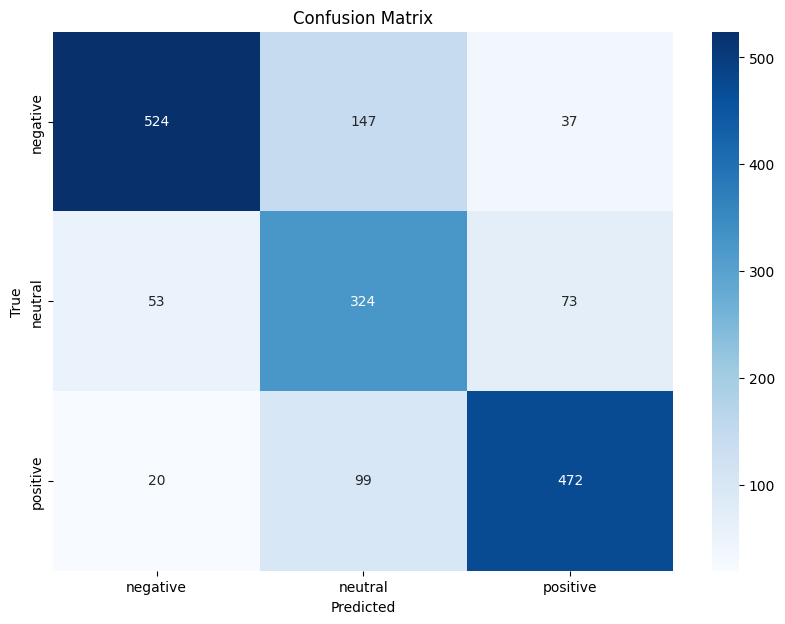

In [12]:

from datasets import load_dataset, Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the CSV file into a pandas DataFrame
df = pd.read_csv('all_sampled_twitter.csv')

# Split the DataFrame into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)


train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Create a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})
tokenized_datasets = dataset.map(preprocess_function, batched=True)
predictions = trainer.predict(tokenized_datasets['test'])
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)

accuracy = accuracy_score(tokenized_datasets['test']['label'], predicted_labels)
precision = precision_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')
recall = recall_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')
f1_score_ = f1_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')

print(f'Tweet Accuracy: {accuracy}')
print(f'Tweet Precision: {precision}')
print(f'Tweet Recall: {recall}')
print(f'Tweet F1 Score: {f1_score_}')
print(f'Tweet Accuracy: {accuracy}')

conf_matrix = confusion_matrix(tokenized_datasets['test']['labels'], predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()